In [25]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from os import listdir
import data_visualization as dv
import dill
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm 
from scipy.signal import find_peaks
'''
This script pulls
1. Decision array of agent and player
2. Decision time of agent and player
   - Possibly calculate this with velocity in the future
3. Control things
   - Reaction times, interval target reach times, coincidence target reach times
   
   
*****v2 GOES BACK TO THE REACTION WITH THE CIRCLES INSTEAD OF THE AGENT****
'''

'\nThis script pulls\n1. Decision array of agent and player\n2. Decision time of agent and player\n   - Possibly calculate this with velocity in the future\n3. Control things\n   - Reaction times, interval target reach times, coincidence target reach times\n   \n   \n*****v2 GOES BACK TO THE REACTION WITH THE CIRCLES INSTEAD OF THE AGENT****\n'

In [26]:
# Fields pull and pull list
os.chdir('D:\Subject_Data\Agent_Shutoff_Go')
PATH = os.getcwd()
analysis_pull_list = []
        
with open(PATH+"\\Analysis_Pull_List.txt", "r") as file:
    analysis_pull_list = file.read().splitlines()

# with open(PATH+"\\Analysis_Pull_List_Control.txt", "r") as pull_file:
#     analysis_pull_list_control = pull_file.read().splitlines()
# with open(PATH+"\\Analysis_Pull_List_Task.txt", "r") as pull_file:
#     analysis_pull_list_task = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
    
num_subjects = len(analysis_pull_list)
task_name = 'Agent_Shutoff_Go'

Target information

- Row 0 = Start Target

- Row 1 = Left screen, right target x pos (left target is 2*startx - right targetx)

- Dim 1 = Radius

- Dim 2 = Thickness of the circle edge (don't know if this matters)


Dataframe is in centimeters, so need to divide everything by 100

In [27]:
file = PATH+'\\Sub1\\Sub1Target_Table.csv'
df = pd.read_csv(file)
df["X"] = df["X"]/100
df["Y"] = df["Y"]/100
df['Dim 1'] = df['Dim 1']/100 # Target table is in centimeters, I guess this doesn't matter but it makes me feel better
df['Dim 2'] = df['Dim 2']/100
# Target information for Right Hand (keeping this because the positions of target 3 and 4 are based on target 1 and start 1)
startx = df.loc[0]['X']
starty = df.loc[0]['Y']
start_radius = df.loc[0]['Dim 1'] 

target1x = df.loc[1]['X']
target1y = df.loc[1]['Y']
target1_radius = df.loc[1]['Dim 1']

target2x = 2*startx - target1x
target2y = target1y
target2_radius = target1_radius

# Timing target
timing_targetx = startx
timing_targety = target1y
timing_target_pos = np.sqrt(timing_targetx**2 + timing_targety**2)
timing_target_radius = target1_radius   

In [28]:
#%% Get reaction time data
block_table = pd.read_csv(PATH+f'\\Sub1\\Sub1Block_Table.csv')
num_trials = block_table['List_Reps'].loc[0]
num_blocks = sum(~block_table['TP_LIST'].isna())
trial_time = 2500
tot_trials = int(sum(block_table['List_Reps']))

filenames = np.empty((num_subjects, num_blocks,num_trials),dtype = object)
trial_start = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
agent_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan

player_decision_array = np.empty((num_subjects, num_blocks,num_trials))*np.nan
player_decision_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_plus_movement_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_reach_time = np.zeros((num_subjects, num_blocks,num_trials))*np.nan
player_reaction_time_vel = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

trial_type_array = np.zeros((num_subjects, num_blocks,num_trials))*np.nan

data = np.zeros((num_subjects, num_blocks,num_trials, trial_time, 2))*np.nan

###-------------------------------------------------------------------------------------------------------
for i in range(num_subjects):
    subname = analysis_pull_list[i]
    print(i, subname)
    path1 = PATH+'\\'+subname
    trial_table = pd.read_csv(path1+f'\\{subname}Trial_Table.csv')
    for x in ((range(tot_trials))):
        block_number = trial_table.iloc[x]['Block_Row']
        tp_num = trial_table.iloc[x]['TP_Row']
        block_trial_num = trial_table.iloc[x]['Block_Step']
        filename = PATH+f"\\{subname}\\{task_name}_{subname}_C{block_number}_TP{tp_num}_T{block_trial_num}.csv"
        j = tp_num - 1 # Block number
        k = block_trial_num - 1 # Trial number in that block
        filenames[i,j,k] = filename
        data = pd.read_csv(filename, low_memory=False)
        event_code_col = data['Event_Codes']
        # if 'E_REDO_TRIAL' in event_code_col.unique():
        #     data_start = data.index[data['Event_Codes']=='E_REDO_TRIAL']
        #     data = data.iloc[data_start[-1]:]
        if 'E_GO_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_GO_TRIAL'].index[-1])
            trial_type_array[i,j,k] = 1
        elif 'E_SHUTOFF_TRIAL' in event_code_col.unique():
            start_time = int(data[data['Event_Codes']=='E_SHUTOFF_TRIAL'].index[-1])
            trial_type_array[i,j,k] = 0
        else:
            raise Exception('ERROR, event code not found')
            
        # Get Reaction Time Data
        end_time = start_time + trial_time
        trial_start[i,j,k] = start_time
        agent_decision_time[i,j,k] = data.iloc[start_time]['Agent_Decision_Time']
        
        lhx = np.array(data.iloc[start_time:end_time]['Left_HandX'])
        lhy = np.array(data.iloc[start_time:end_time]['Left_HandY'])
        lhx_vel = np.array(data.iloc[start_time:end_time]['Left_HandXVel'])
        lhy_vel = np.array(data.iloc[start_time:end_time]['Left_HandYVel'])
        q = np.argwhere(np.sqrt((lhx-target1x)**2 + (lhy-target1y)**2) < target1_radius)
        r = np.argwhere(np.sqrt((lhx-target2x)**2 + (lhy-target2y)**2) < target2_radius) 
        s = np.argwhere(np.sqrt((lhx-startx)**2 + (lhy-starty)**2) > start_radius*1) # Multiplied by 1.2 so people don't accidentally drift outside start
        
        t = np.argwhere(np.sqrt((lhx_vel)**2 + (lhy_vel)**2) > 0.05)
        speed = np.sqrt((lhx_vel)**2 + (lhy_vel)**2)

        if np.size(t)>0:
            player_reaction_time_vel[i,j,k] = t[0] - agent_decision_time[i,j,k]

        if np.size(s)>0: 
            player_decision_time[i,j,k] = s[0]
            player_reaction_time[i,j,k] = s[0]  - agent_decision_time[i,j,k]
        if np.size(q)>0: #if LH enters right target
            player_decision_array[i,j,k] = 1
            player_movement_time[i,j,k] = q[0] - s[0]
            player_reaction_plus_movement_time[i,j,k] = q[0] - agent_decision_time[i,j,k]
            
        elif np.size(r)>0: #if LH enters left target
            player_decision_array[i,j,k] = -1   
            player_movement_time[i,j,k] = r[0] - s[0]
            player_reaction_plus_movement_time[i,j,k] = r[0] - agent_decision_time[i,j,k]          
            
        # #plot path for Reactions
        if False:
            for i in range(1):
                plot_end_time = int(agent_decision_time[i,j,k] + player_reaction_time[i,j,k])
                # plot_end_time = int(start_time + 500)
                lhx_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandX'])
                lhy_new = np.array(data.iloc[start_time:int(start_time+s[0][0])]['Left_HandY'])
                plt.figure(dpi=300)
                circleR = plt.Circle((target1x,target1y), target1_radius, color = 'r', fill = False)
                circleL = plt.Circle((target2x,target2y), target2_radius, color = 'r', fill = False)
                startCirc = plt.Circle((startx,starty), start_radius, color = 'r', fill = False)
                fig, ax = plt.subplots()
                ax.add_patch(circleR)
                ax.add_patch(circleL)
                ax.add_patch(startCirc)
                plt.plot(lhx_new,lhy_new) 
                # plt.scatter(lhx_new[int(s[0])], lhy_new[int(s[0])])
                print(player_reaction_time[i,j,k])
                # plt.title("w =%1.0f " %i + "x=%1.0f "%j + "c=%1.0f"%k + 'vely=%1.5f'%vel_check)
                plt.show()
shutoff_mask = trial_type_array == 0
go_mask = trial_type_array == 1
player_shutoff_reaction_time = player_reaction_time*shutoff_mask     
player_shutoff_reaction_time[~shutoff_mask] = np.nan      
player_go_reaction_time = player_reaction_time*go_mask          
player_go_reaction_time[~go_mask] = np.nan      
 

0 Sub1
1 Sub2
2 Sub3
3 Sub4
4 Sub5
5 Sub6


In [29]:
nanmask1 = np.isnan(player_go_reaction_time)
reaction_time_react_switch = np.nanmedian(player_go_reaction_time[0,0,:][~nanmask1[0,0,:]])
reaction_time_react = np.nanmedian(player_go_reaction_time[0,1,:][~nanmask1[0,1,:]])

nanmask2 = np.isnan(player_shutoff_reaction_time)
reaction_time_gamble_switch = np.nanmedian(player_shutoff_reaction_time[0,0,:][~nanmask2[0,0,:]])
reaction_time_gamble = np.nanmedian(player_shutoff_reaction_time[0,2,:][~nanmask2[0,2,:]])

In [30]:
print(reaction_time_react_switch)
print(reaction_time_react)
print(reaction_time_gamble_switch)
print(reaction_time_gamble)

317.8772583007815
310.5714111328125
374.9945068359375
294.00479125976597


In [31]:
nanmask1 = np.isnan(player_go_reaction_time)
reaction_time_react_switch = (player_go_reaction_time[0,0,:][~nanmask1[0,0,:]])
reaction_time_react = (player_go_reaction_time[0,1,:][~nanmask1[0,1,:]])

nanmask2 = np.isnan(player_shutoff_reaction_time)
reaction_time_gamble_switch = (player_shutoff_reaction_time[0,0,:][~nanmask2[0,0,:]])
reaction_time_gamble = (player_shutoff_reaction_time[0,2,:][~nanmask2[0,2,:]])

[Text(0, 0, 'React (Switch)'),
 Text(1, 0, 'React (Only React)'),
 Text(2, 0, 'Gamble (Switch)'),
 Text(3, 0, 'Gamble (Only Gamble)')]

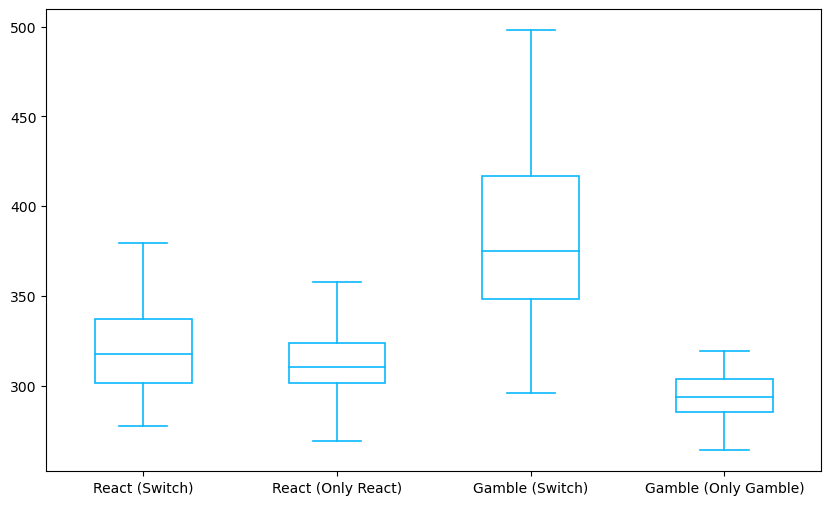

In [32]:
fig,ax = plt.subplots(figsize = (10,6))
dv.boxplot(reaction_time_react_switch,x_pos = 0,ax=ax)
dv.boxplot(reaction_time_react,x_pos = 1,ax=ax)
dv.boxplot(reaction_time_gamble_switch,x_pos = 2,ax=ax)
dv.boxplot(reaction_time_gamble,x_pos = 3,ax=ax)
xlabs = ['React (Switch)','React (Only React)','Gamble (Switch)','Gamble (Only Gamble)']
ax.set_xticklabels(xlabs)

[Text(0, 0, 'React (Switch)'),
 Text(1, 0, 'React (Only React)'),
 Text(2, 0, 'Gamble (Switch)'),
 Text(3, 0, 'Gamble (Only Gamble)')]

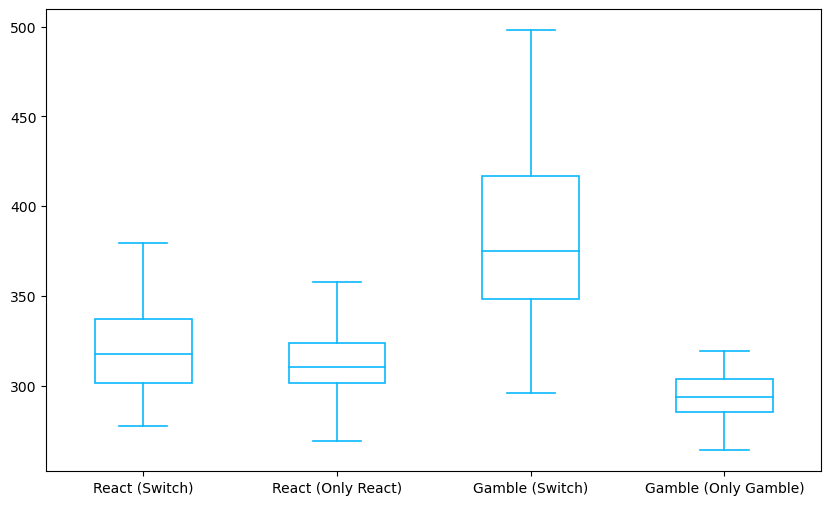

In [33]:
fig,ax = plt.subplots(figsize = (10,6))
dv.boxplot(reaction_time_react_switch,x_pos = 0,ax=ax)
dv.boxplot(reaction_time_react,x_pos = 1,ax=ax)
dv.boxplot(reaction_time_gamble_switch,x_pos = 2,ax=ax)
dv.boxplot(reaction_time_gamble,x_pos = 3,ax=ax)
xlabs = ['React (Switch)','React (Only React)','Gamble (Switch)','Gamble (Only Gamble)']
ax.set_xticklabels(xlabs)

In [34]:
reaction_time_react_switch = np.nanstd(player_go_reaction_time[0,0,:])
reaction_time_react = np.nanstd(player_go_reaction_time[0,1,:])

reaction_time_gamble_switch = np.nanstd(player_shutoff_reaction_time[0,0,:])
reaction_time_gamble = np.nanstd(player_shutoff_reaction_time[0,2,:])

In [35]:
print(reaction_time_react_switch)
print(reaction_time_react)
print(reaction_time_gamble_switch)
print(reaction_time_gamble)

36.35903342997499
27.792968081259946
108.82623077360638
25.74410508525777


In [36]:
i=-1
for subname in analysis_pull_list:
    i+=1
    data_path = PATH+f'\\Subjects_Analyzed\\{subname}\\'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    print(subname)
    print(data_path)
    print(player_reaction_time)
    dill.dump(player_reaction_time[i,:,:], open(data_path + f'{subname}_player_reaction_time.pkl', 'wb'))
    dill.dump(trial_type_array[i,:,:], open(data_path + f'{subname}_trial_type_array.pkl', 'wb'))
    # dill.dump(agent_decision_time[i,:], open(data_path + f'{subname}_agent_decision_time.pkl', 'wb'))


Sub1
D:\Subject_Data\Agent_Shutoff_Go\Subjects_Analyzed\Sub1\
[[[369.62176514 277.42407227 359.11334229 ... 398.32904053 320.98712158
   357.46954346]
  [317.12139893 324.37121582 304.18121338 ...          nan          nan
            nan]
  [308.9954834  277.27661133 283.67974854 ...          nan          nan
            nan]]

 [[669.62176514 395.42547607 432.5579834  ... 540.88494873 355.77624512
   407.05621338]
  [308.12646484 279.79931641 270.08270264 ...          nan          nan
            nan]
  [332.66363525 284.00982666 276.73742676 ...          nan          nan
            nan]]

 [[582.62176514 348.42407227 389.11334229 ... 422.33496094 301.08184814
   409.45727539]
  [385.54492188 323.24316406 272.90802002 ...          nan          nan
            nan]
  [371.9954834  299.27661133 292.67974854 ...          nan          nan
            nan]]

 [[420.62176514 509.11334229 936.69647217 ... 371.45727539 387.20697021
   476.39349365]
  [464.08398438 295.52655029 314.78875732 